In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [4]:
class_names=dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset)

645

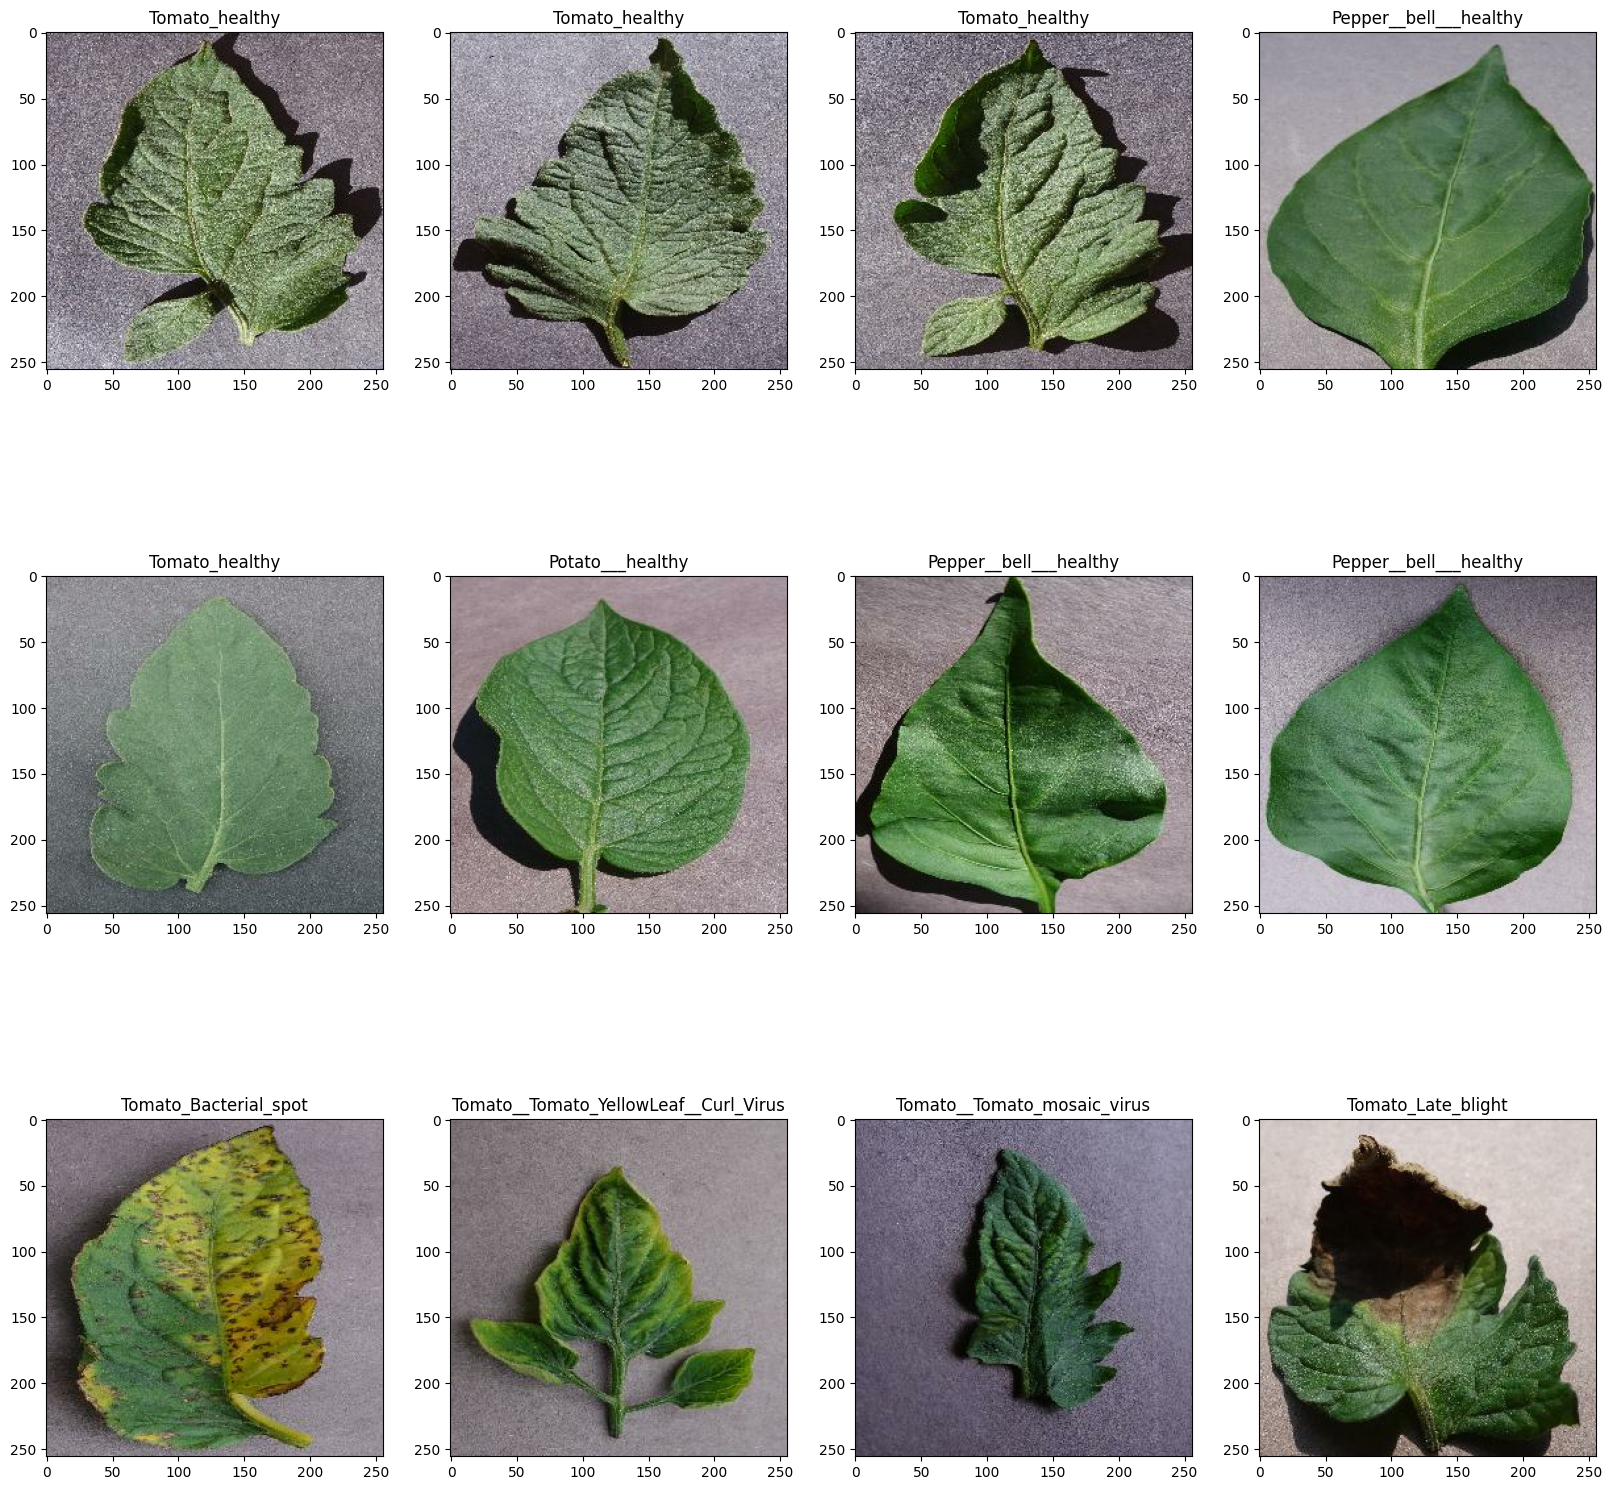

In [6]:
plt.figure(figsize=(20,20))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)    
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [7]:
len(dataset)

645

80% ==> training
20% ==> 10% validation , 10% test

In [8]:
train_size = 0.8
len(dataset)*train_size

516.0

In [9]:
train_ds = dataset.take(516)
len(train_ds)

516

In [10]:
test_ds = dataset.skip(516)
len(test_ds)

129

In [11]:
val_size = 0.1
len(dataset)*val_size

64.5

In [12]:
val_ds =test_ds.take(64)
len(val_ds)

64

In [13]:
test_ds = test_ds.skip(64)
len(test_ds)

65

In [14]:
 def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
        
        ds_size=len(ds)
        
        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
             
        train_size = int(train_split * ds_size)
        val_size = int(val_split* ds_size)
        
        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size) 
        test_ds = ds.skip(train_size).skip(val_size)
        
        return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

516

In [17]:
len(val_ds)

64

In [18]:
len(test_ds)

65

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation ='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [24]:
 model.compile(
     optimizer='adam',
     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
     metrics=['accuracy']
 )

In [25]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/30
516/516 [==============================] - 889s 1s/step - loss: 2.0863 - accuracy: 0.3157 - val_loss: 1.6869 - val_accuracy: 0.4458
Epoch 2/30
516/516 [==============================] - 259s 501ms/step - loss: 1.2488 - accuracy: 0.5885 - val_loss: 1.0823 - val_accuracy: 0.6411
Epoch 3/30
516/516 [==============================] - 237s 460ms/step - loss: 0.8206 - accuracy: 0.7270 - val_loss: 0.8378 - val_accuracy: 0.7251
Epoch 4/30
516/516 [==============================] - 210s 407ms/step - loss: 0.5968 - accuracy: 0.7969 - val_loss: 0.9289 - val_accuracy: 0.7314
Epoch 5/30
516/516 [==============================] - 226s 438ms/step - loss: 0.4689 - accuracy: 0.8411 - val_loss: 0.5036 - val_accuracy: 0.8247
Epoch 6/30
516/516 [==============================] - 222s 431ms/step - loss: 0.4254 - accuracy: 0.8566 - val_loss: 0.5541 - val_accuracy: 0.8203
Epoch 7/30
516/516 [==============================] - 155s 301ms/step - loss: 0.3698 - accuracy: 0.8722 - val_loss: 0.3873 - va

In [26]:
score = model.evaluate(test_ds)

65/65 [==============================] - 650s 181ms/step - loss: 0.1398 - accuracy: 0.9495


In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 516}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

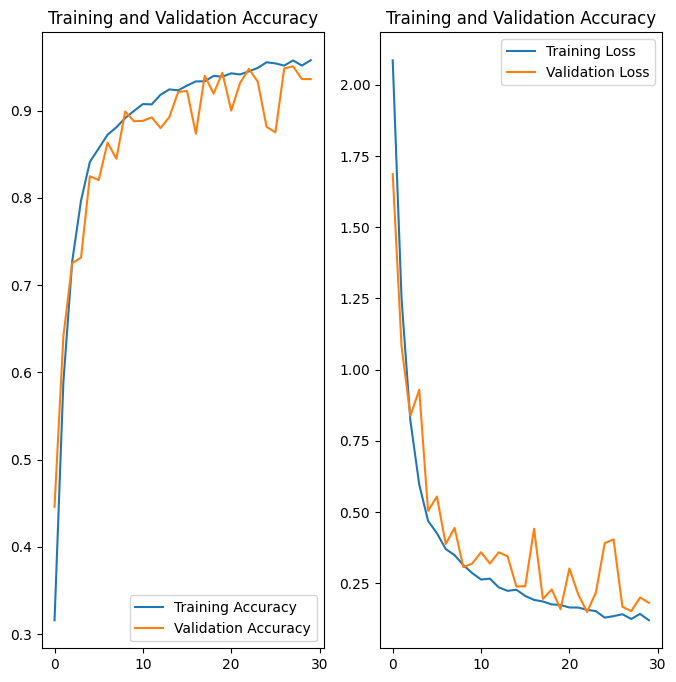

In [31]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()

First image to predict
First image's actual label: Tomato_healthy
predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus


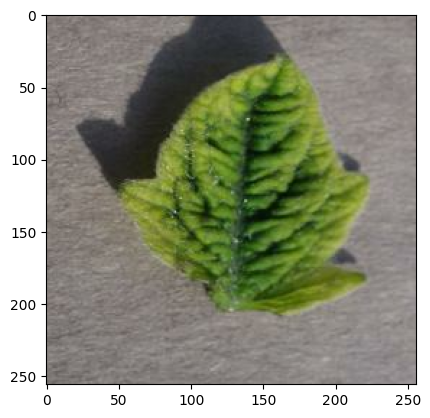

In [32]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    
    return predicted_class, confidence

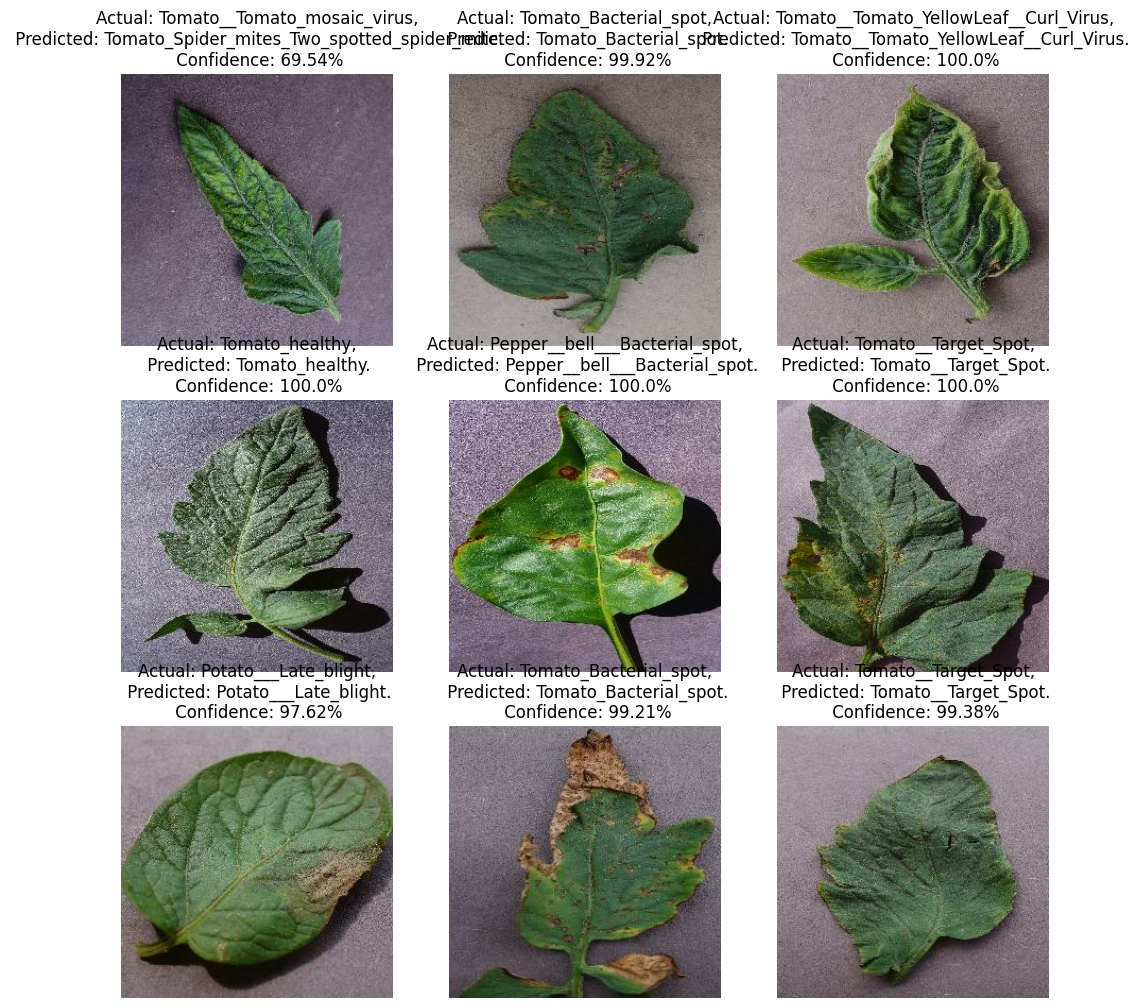

In [34]:
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [37]:
model_version=1
model.save(f"../models/disease_pred/{model_version}")

INFO:tensorflow:Assets written to: ../models/disease_pred/1\assets


# model version auto increment

In [38]:

#import os
#model_version = max([int(i) for i in os.listdir("../models") + [0]] +1) 
#model.save(f"../models/{model_version}")
